In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, save_img
from sklearn.model_selection import train_test_split

# Definir la ruta del archivo CSV
file_path = r'D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\reconocimiento-de-expresiones-faciales\train_set.csv'

# Cargar datos del CSV
data = pd.read_csv(file_path)
data['path'] = data['path'].str.replace('\\', os.sep)  # Ajustar las rutas para el sistema operativo

# Definir dimensiones de las imágenes
img_height, img_width = 48, 48

# Cargar imágenes y etiquetas
images = []
labels = []

for index, row in data.iterrows():
    img_path = os.path.join('D:\\DATASCIENCE\\Repositorios\\Kaggle_Desafio_Imagenes\\reconocimiento-de-expresiones-faciales', row['path'])
    label = row['label']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    image = cv2.resize(image, (img_width, img_height))  # Redimensionar
    images.append(image)
    labels.append(label)

# Convertir a arrays de NumPy
images = np.array(images).reshape(-1, img_height, img_width, 1)  # Añadir dimensión de canal
labels = np.array(labels)

# Codificar etiquetas a categorías
label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = np.array([label_map[label] for label in labels])
labels = to_categorical(labels)

# Configurar data augmentation para generar un duplicado de imagenes pero con modificaciones.
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directorio para guardar las imágenes modificadas
augmented_dir = r'D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\reconocimiento-de-expresiones-faciales\augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

# Generar y guardar imágenes aumentadas
augmented_images = []
augmented_labels = []

for i, image in enumerate(images):
    image = np.expand_dims(image, axis=0)  
    label = labels[i]
    
    j = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_image = batch[0]
        img_name = f'aug_{i}_{j}.png'
        img_path = os.path.join(augmented_dir, img_name)
        save_img(img_path, augmented_image)
        
        augmented_images.append(augmented_image)
        augmented_labels.append(label)
        
        j += 1
        if j >= 1: 
            break

# Convertir listas a arrays de NumPy
augmented_images = np.array(augmented_images).reshape(-1, img_height, img_width, 1)
augmented_labels = np.array(augmented_labels)

In [3]:
# Combinar imágenes y etiquetas originales con las aumentadas
X_train = np.concatenate((images, augmented_images), axis=0)
y_train = np.concatenate((labels, augmented_labels), axis=0)

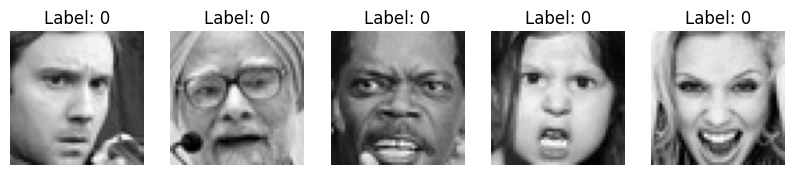

In [34]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes con sus etiquetas
num_images_to_display = 5  # Número de imágenes a mostrar
plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i].reshape(img_height, img_width), cmap='gray')
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis('off')
plt.show()


In [3]:
ssssssssssssssssssss

NameError: name 'ssssssssssssssssssss' is not defined

In [61]:
label_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [5]:
from sklearn.model_selection import train_test_split

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Conv2D, BatchNormalization, LeakyReLU, Input, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def se_block(input_tensor, ratio=8):
    # Squeeze and Excitation block implementation
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

input_tensor = Input(shape=(48, 48, 1))

x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001))(input_tensor)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = se_block(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Flatten()(x)
x = Dense(1024, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.4)(x)

x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.4)(x)

output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model_top.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

# Image Data Generators with different augmentations
train_datagen_1 = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)
train_datagen_2 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_datagen_3 = ImageDataGenerator(rescale=1./255, brightness_range=[0.8, 1.2], fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_1 = train_datagen_1.flow(X_train, y_train, batch_size=128)
train_generator_2 = train_datagen_2.flow(X_train, y_train, batch_size=128)
train_generator_3 = train_datagen_3.flow(X_train, y_train, batch_size=128)

val_generator = val_datagen.flow(X_val, y_val, batch_size=128)

# Training the model with different data generators
history_1 = model.fit(
    train_generator_1,
    epochs=150,
    validation_data=val_generator,
    callbacks=callbacks
)

history_2 = model.fit(
    train_generator_2,
    epochs=150,
    validation_data=val_generator,
    callbacks=callbacks
)

history_3 = model.fit(
    train_generator_3,
    epochs=150,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/150


c:\Users\raul_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.2084 - loss: 5.3841
Epoch 1: val_loss improved from inf to 4.96566, saving model to best_model_top.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 131s 347ms/step - accuracy: 0.2084 - loss: 5.3837 - val_accuracy: 0.1937 - val_loss: 4.9657 - learning_rate: 1.0000e-04
Epoch 2/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2469 - loss: 4.9668
Epoch 2: val_loss improved from 4.96566 to 4.69985, saving model to best_model_top.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 344ms/step - accuracy: 0.2469 - loss: 4.9667 - val_accuracy: 0.2848 - val_loss: 4.6999 - learning_rate: 1.0000e-04
Epoch 3/150
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.2833 - loss: 4.6822
Epoch 3: val_loss improved from 4.69985 to 4.38537, saving model to best_model_top.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 335ms/step - accuracy: 0.2834 - loss: 4.6820 - val_accuracy: 0.3528 - val_loss: 4.3854 - learning_rate: 1.0000e-04
Epoch 4/150
361/361 ━━━━━━━━━━━━━━━

REENTRENO 2 IMAGEN GENERATOR

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definición del bloque SE
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

# Cargar el modelo existente
model = load_model('best_model_top.keras', custom_objects={'Multiply': Multiply, 'GlobalAveragePooling2D': GlobalAveragePooling2D})

# Verificar si la salida del modelo es una lista
if isinstance(model.output, list):
    x = model.output[0]  # Seleccionar el primer tensor de la lista
else:
    x = model.output

# Inspeccionar la salida del modelo existente
print(f"Output shape of the loaded model: {x.shape}")

# Ajustar el modelo: aumentar Dropout y añadir capas si es necesario
input_tensor = model.input

x = Dense(1024, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.5)(x)  # Aumentar Dropout

x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.5)(x)  # Aumentar Dropout

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.5)(x)  # Aumentar Dropout

output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo ajustado
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model_retrained.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

# Image Data Generators con diferentes aumentos de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de entrenamiento y validación
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

# Reentrenar el modelo con los generadores de datos
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)


Output shape of the loaded model: (None, 7)
Epoch 1/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3797 - loss: 3.1928
Epoch 1: val_loss improved from inf to 2.41300, saving model to best_model_retrained.keras
721/721 ━━━━━━━━━━━━━━━━━━━━ 157s 209ms/step - accuracy: 0.3798 - loss: 3.1925 - val_accuracy: 0.5941 - val_loss: 2.4130 - learning_rate: 1.0000e-04
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5096 - loss: 2.6363
Epoch 2: val_loss improved from 2.41300 to 2.27353, saving model to best_model_retrained.keras
721/721 ━━━━━━━━━━━━━━━━━━━━ 142s 196ms/step - accuracy: 0.5096 - loss: 2.6362 - val_accuracy: 0.6142 - val_loss: 2.2735 - learning_rate: 1.0000e-04
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5229 - loss: 2.4990
Epoch 3: val_loss improved from 2.27353 to 2.19616, saving model to best_model_retrained.keras
721/721 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - accuracy: 0.5229 - loss: 2.4990 - val_accuracy: 0.6301 - val_loss:

REENTRENO 3 IMAGEN GENERATOR

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definición del bloque SE
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

# Cargar el modelo existente
model = load_model('best_model_retrained.keras', custom_objects={'Multiply': Multiply, 'GlobalAveragePooling2D': GlobalAveragePooling2D})

# Verificar si la salida del modelo es una lista
if isinstance(model.output, list):
    x = model.output[0]  # Seleccionar el primer tensor de la lista
else:
    x = model.output

# Inspeccionar la salida del modelo existente
print(f"Output shape of the loaded model: {x.shape}")

# Ajustar el modelo: aumentar Dropout y añadir capas si es necesario
input_tensor = model.input

x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.6)(x)  # Aumentar Dropout

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.6)(x)  # Aumentar Dropout

output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo ajustado
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model_retrained_2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

# Image Data Generators con diferentes aumentos de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.4,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de entrenamiento y validación
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Reentrenar el modelo con los generadores de datos
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks

)

Output shape of the loaded model: (None, 7)
Epoch 1/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4115 - loss: 2.2862
Epoch 1: val_loss improved from inf to 1.64866, saving model to best_model_retrained_2.keras
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 178s 119ms/step - accuracy: 0.4116 - loss: 2.2861 - val_accuracy: 0.6197 - val_loss: 1.6487 - learning_rate: 1.0000e-04
Epoch 2/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5166 - loss: 1.9307
Epoch 2: val_loss did not improve from 1.64866
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 167s 116ms/step - accuracy: 0.5166 - loss: 1.9306 - val_accuracy: 0.5617 - val_loss: 1.7744 - learning_rate: 1.0000e-04
Epoch 3/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5503 - loss: 1.7865
Epoch 3: val_loss improved from 1.64866 to 1.49930, saving model to best_model_retrained_2.keras
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 171s 118ms/step - accuracy: 0.5503 - loss: 1.7865 - val_accuracy: 0.6517 - val_loss: 1.4993 - learning_rate: 5.0000e

REENTRENO CON PESOS CLASES

In [84]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# Cargar el modelo existente
model = load_model('best_model_retrained_2.keras', custom_objects={'Multiply': Multiply, 'GlobalAveragePooling2D': GlobalAveragePooling2D})

# Inspeccionar la salida del modelo existente
if isinstance(model.output, list):
    x = model.output[0]  # Seleccionar el primer tensor de la lista
else:
    x = model.output

input_tensor = model.input

# Añadir capas adicionales con Dropout y Swish
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)  # Cambiar a Swish
x = Dropout(0.5)(x)  # Ajustar Dropout

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)  # Cambiar a Swish
x = Dropout(0.5)(x)  # Ajustar Dropout

output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo ajustado con AdamW
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Aplicar SMOTE a los datos de entrenamiento aplanados
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))  # Aplanar las imágenes
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

# Restaurar la forma original de las imágenes después de SMOTE
X_train_resampled = X_train_resampled.reshape((-1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled, num_classes=7)

# Calcular los pesos de las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train_resampled, axis=1)),
    y=np.argmax(y_train_resampled, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_delta=0.001, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model_retrained_3.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

# Image Data Generators con diferentes aumentos de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de entrenamiento y validación
train_generator = train_datagen.flow(X_train_resampled, y_train_resampled, batch_size=128)
val_generator = val_datagen.flow(X_val, y_val, batch_size=128)

# Reentrenar el modelo con los generadores de datos y balance de clases ajustado
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/50


c:\Users\raul_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4683 - loss: 2.1489
Epoch 1: val_loss improved from inf to 1.71769, saving model to best_model_retrained_3.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 229s 352ms/step - accuracy: 0.4683 - loss: 2.1487 - val_accuracy: 0.6218 - val_loss: 1.7177 - learning_rate: 1.0000e-04
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5559 - loss: 1.8789
Epoch 2: val_loss improved from 1.71769 to 1.60407, saving model to best_model_retrained_3.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 216s 343ms/step - accuracy: 0.5559 - loss: 1.8789 - val_accuracy: 0.6491 - val_loss: 1.6041 - learning_rate: 1.0000e-04
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5799 - loss: 1.7687
Epoch 3: val_loss improved from 1.60407 to 1.53041, saving model to best_model_retrained_3.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 216s 343ms/step - accuracy: 0.5799 - loss: 1.7687 - val_accuracy: 0.6490 - val_loss: 1.5304 - learning_rate: 1.0000e-04
Epoch 4/50
62

KeyboardInterrupt: 

REENTRENO SMOTE 2

In [97]:
model.load_weights('best_model_retrained_2.keras')

c:\Users\raul_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 214 variables whereas the saved optimizer has 194 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 5 objects could not be loaded. Example error message for object <Dense name=dense_148, built=True>:

Layer 'dense_148' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense_148, built=True>, <BatchNormalization name=batch_normalization_79, built=True>, <Dense name=dense_149, built=True>, <BatchNormalization name=batch_normalization_80, built=True>, <Dense name=dense_150, built=True>]

In [86]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Precisión en el conjunto de validación: {val_accuracy:.2f}")
print(f"Pérdida en el conjunto de validación: {val_loss:.2f}")

Precisión en el conjunto de validación: 0.70
Pérdida en el conjunto de validación: 1.05


In [87]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado
model = load_model('best_model_retrained_2.keras')


# Predicciones en el conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Evaluar el rendimiento
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))


361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
              precision    recall  f1-score   support

           0       0.16      0.14      0.15      1602
           1       0.02      0.22      0.03       195
           2       0.16      0.11      0.13      1706
           3       0.22      0.21      0.21      2841
           4       0.17      0.07      0.10      1938
           5       0.17      0.02      0.04      1975
           6       0.10      0.21      0.13      1272

    accuracy                           0.13     11529
   macro avg       0.14      0.14      0.11     11529
weighted avg       0.17      0.13      0.13     11529

[[223 313 137 389 111  36 393]
 [ 18  43  16  50   9   9  50]
 [181 356 188 440 116  30 395]
 [383 584 290 599 238  49 698]
 [259 378 201 435 141  41 483]
 [222 407 208 465 156  39 478]
 [126 273 148 365  72  20 268]]


In [49]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta del archivo CSV de prueba y de las imágenes
test_file_path = 'sample_submision.csv'
image_base_path = r'D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test'

# Cargar datos del CSV de prueba
test_data = pd.read_csv(test_file_path)
print(f"CSV Loaded: {test_data.head()}")  # Verificar que el CSV se ha cargado correctamente
test_data['path'] = test_data['id_img'].astype(str).str.replace('\\', os.sep) 
# Cargar imágenes de prueba
test_images = []

for index, row in test_data.iterrows():
    img_name = row['id_img']  # Asume que la columna con el nombre de la imagen es 'id_img'
    img_path = os.path.join(image_base_path, f"{img_name}.jpg")
    print(f"Processing image: {img_path}")  # Imprimir la ruta de la imagen para verificar
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image, (48, 48))  # Redimensionar a 48x48 píxeles
        image = image  / 255.0
        test_images.append(image)
    else:
        print(f"Image not found: {img_path}")  # Imprimir si la imagen no se encuentra

test_images = np.array(test_images).reshape(-1, 48, 48, 1)

# Verificar el número de imágenes de prueba cargadas
print(f"Total test images: {len(test_images)}")

CSV Loaded:    id_img     label
0   10052  surprise
1   10065  surprise
2   10079  surprise
3   10095  surprise
4   10121  surprise
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10052.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10065.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10079.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10095.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10121.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10148.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10163.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\10215.jpg
Processing image: D:\DATASCIENCE\Repositorios\Kaggle_Desafio_Imagenes\data\images\test\1024.

In [50]:
# Verificar el número de imágenes de prueba cargadas
print(f"Total test images: {len(test_images)}")

Total test images: 7066


In [88]:
# Realizar predicciones
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Mapear predicciones a etiquetas
inverse_label_map = {v: k for k, v in label_map.items()}
predicted_labels = [inverse_label_map[pred] for pred in predicted_classes]

# Agregar etiquetas al DataFrame de prueba
test_data['predicted_label'] = predicted_labels

# Guardar las predicciones en un nuevo archivo CSV (opcional)
test_data.to_csv('submision20.csv', index=False)

221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
